# 05 – Few-Shot Learning & Learning Curves

Ziel: Simulation eines Small-Data-Szenarios (z. B. ~500 Dokumente) durch Training mit
reduzierter Datenmenge pro Klasse. Es wird untersucht, wie sich die Modellleistung
in Abhängigkeit der Anzahl gelabelter Beispiele entwickelt (Learning Curve).

Vergleich: klassische Baseline (TF-IDF + Logistic Regression) vs. Transformer (DistilBERT/BERT).


In [1]:
from pathlib import Path
import time
import numpy as np
import pandas as pd

PROJECT_ROOT = Path.cwd().parent
DATA_CSV = PROJECT_ROOT / "data" / "processed" / "bbc_news.csv"

RESULTS_DIR = PROJECT_ROOT / "results"
RESULTS_DIR.mkdir(exist_ok=True)

FEWSHOT_DIR = RESULTS_DIR / "fewshot_learning"
FEWSHOT_DIR.mkdir(exist_ok=True)

DATA_CSV, FEWSHOT_DIR


(WindowsPath('c:/CAS/cas-ml-document-classification/data/processed/bbc_news.csv'),
 WindowsPath('c:/CAS/cas-ml-document-classification/results/fewshot_learning'))

Daten laden und fester Testsplit

In [2]:
from sklearn.model_selection import train_test_split

df = pd.read_csv(DATA_CSV)

labels_sorted = sorted(df["label"].unique())
label2id = {l:i for i,l in enumerate(labels_sorted)}
id2label = {i:l for l,i in label2id.items()}

X = df["text"].astype(str).values
y = df["label"].map(label2id).values

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

len(X_train_full), len(X_test), labels_sorted


(1780, 445, ['business', 'entertainment', 'politics', 'sport', 'tech'])

Helper: Few-shot Subsampling pro Klasse

In [3]:
def sample_n_per_class(X_train, y_train, n_per_class, seed=42):
    rng = np.random.default_rng(seed)
    idxs = []
    for c in np.unique(y_train):
        class_idx = np.where(y_train == c)[0]
        if n_per_class > len(class_idx):
            raise ValueError(f"Class {c} has only {len(class_idx)} samples, requested {n_per_class}")
        chosen = rng.choice(class_idx, size=n_per_class, replace=False)
        idxs.extend(chosen.tolist())
    idxs = np.array(idxs)
    return X_train[idxs], y_train[idxs]


Baseline Trainer & Metrics

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

def train_eval_baseline(X_tr, y_tr, X_te, y_te):
    model = Pipeline([
        ("tfidf", TfidfVectorizer(max_features=50000, ngram_range=(1,2), stop_words="english")),
        ("clf", LogisticRegression(max_iter=2000, n_jobs=-1))
    ])
    t0 = time.time()
    model.fit(X_tr, y_tr)
    train_time = time.time() - t0

    pred = model.predict(X_te)
    return {
        "accuracy": float(accuracy_score(y_te, pred)),
        "macro_f1": float(f1_score(y_te, pred, average="macro")),
        "train_time_sec": float(train_time)
    }


Transformer Runner – für Few-shot

In [5]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [6]:
def train_eval_transformer(X_tr, y_tr, X_te, y_te,
                           model_name="distilbert-base-uncased",
                           max_length=128, epochs=3, lr=2e-5, batch_size=16, seed=42):

    train_ds = Dataset.from_dict({"text": list(X_tr), "label": list(y_tr)})
    test_ds  = Dataset.from_dict({"text": list(X_te), "label": list(y_te)})

    tokenizer = AutoTokenizer.from_pretrained(model_name)

    def tok(batch):
        return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=max_length)

    train_tok = train_ds.map(tok, batched=True)
    test_tok  = test_ds.map(tok, batched=True)

    train_tok.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
    test_tok.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=len(labels_sorted),
        id2label=id2label,
        label2id=label2id
    ).to(device)

    args = TrainingArguments(
        output_dir=str(FEWSHOT_DIR / f"tmp_{model_name.replace('/', '_')}"),
        num_train_epochs=epochs,
        learning_rate=lr,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        evaluation_strategy="epoch",
        save_strategy="no",
        logging_strategy="no",
        seed=seed,
        report_to="none"
    )

    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = np.argmax(logits, axis=1)
        acc = accuracy_score(labels, preds)
        f1 = f1_score(labels, preds, average="macro")
        return {"accuracy": acc, "macro_f1": f1}

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_tok,
        eval_dataset=test_tok,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    t0 = time.time()
    trainer.train()
    train_time = time.time() - t0

    eval_res = trainer.evaluate()
    return {
        "accuracy": float(eval_res.get("eval_accuracy", np.nan)),
        "macro_f1": float(eval_res.get("eval_macro_f1", np.nan)),
        "train_time_sec": float(train_time)
    }


Few-shot Settings definieren (20 / 50 / 100 / full-per-class)

In [7]:
# N pro Klasse (Few-shot Budgets)
budgets = [20, 50, 100]

# Full = kleinste Klassenanzahl in train split (sicher)
min_class_train = min([(y_train_full == c).sum() for c in np.unique(y_train_full)])
min_class_train


309

In [8]:
budgets_with_full = budgets + [min_class_train]
budgets_with_full


[20, 50, 100, 309]

Runs ausführen: Baseline überall, Transformer nur 3–4 Punkte

In [9]:
rows = []

for n in budgets_with_full:
    print(f"\n=== Budget: {n} per class ===")
    X_tr, y_tr = sample_n_per_class(X_train_full, y_train_full, n_per_class=n, seed=42)

    # Baseline
    base_res = train_eval_baseline(X_tr, y_tr, X_test, y_test)
    rows.append({
        "model": "tfidf+logreg",
        "n_per_class": n,
        **base_res
    })
    print("Baseline:", {k: round(v, 4) if isinstance(v, float) else v for k,v in base_res.items()})

    # Transformer (DistilBERT) – optional bei kleinem n auslassen, falls zu langsam
    if n in [50, 100, min_class_train]:
        tr_res = train_eval_transformer(
            X_tr, y_tr, X_test, y_test,
            model_name="distilbert-base-uncased",
            max_length=128,
            epochs=3,
            lr=2e-5,
            batch_size=16
        )
        rows.append({
            "model": "distilbert-base-uncased",
            "n_per_class": n,
            **tr_res
        })
        print("DistilBERT:", {k: round(v, 4) if isinstance(v, float) else v for k,v in tr_res.items()})



=== Budget: 20 per class ===
Baseline: {'accuracy': 0.9483, 'macro_f1': 0.9475, 'train_time_sec': 1.0006}

=== Budget: 50 per class ===
Baseline: {'accuracy': 0.9753, 'macro_f1': 0.9754, 'train_time_sec': 0.7704}


c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Map:   0%|          | 0/445 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

{'eval_loss': 1.44459867477417, 'eval_accuracy': 0.651685393258427, 'eval_macro_f1': 0.6001262276372713, 'eval_runtime': 0.3372, 'eval_samples_per_second': 1319.706, 'eval_steps_per_second': 83.038, 'epoch': 1.0}


  0%|          | 0/28 [00:00<?, ?it/s]

{'eval_loss': 1.2244971990585327, 'eval_accuracy': 0.9078651685393259, 'eval_macro_f1': 0.9056276239654224, 'eval_runtime': 0.3094, 'eval_samples_per_second': 1438.302, 'eval_steps_per_second': 90.5, 'epoch': 2.0}


  0%|          | 0/28 [00:00<?, ?it/s]

{'eval_loss': 1.1320533752441406, 'eval_accuracy': 0.9123595505617977, 'eval_macro_f1': 0.9107290971656674, 'eval_runtime': 0.3168, 'eval_samples_per_second': 1404.829, 'eval_steps_per_second': 88.394, 'epoch': 3.0}
{'train_runtime': 3.1169, 'train_samples_per_second': 240.626, 'train_steps_per_second': 15.4, 'train_loss': 1.3585991859436035, 'epoch': 3.0}


  0%|          | 0/28 [00:00<?, ?it/s]

DistilBERT: {'accuracy': 0.9124, 'macro_f1': 0.9107, 'train_time_sec': 3.7402}

=== Budget: 100 per class ===
Baseline: {'accuracy': 0.9685, 'macro_f1': 0.9685, 'train_time_sec': 0.9644}


c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/445 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

{'eval_loss': 1.0507501363754272, 'eval_accuracy': 0.9483146067415731, 'eval_macro_f1': 0.948481909072288, 'eval_runtime': 0.3057, 'eval_samples_per_second': 1455.453, 'eval_steps_per_second': 91.579, 'epoch': 1.0}


  0%|          | 0/28 [00:00<?, ?it/s]

{'eval_loss': 0.5832697749137878, 'eval_accuracy': 0.9662921348314607, 'eval_macro_f1': 0.9671064194152104, 'eval_runtime': 0.3052, 'eval_samples_per_second': 1458.009, 'eval_steps_per_second': 91.74, 'epoch': 2.0}


  0%|          | 0/28 [00:00<?, ?it/s]

{'eval_loss': 0.46148401498794556, 'eval_accuracy': 0.9685393258426966, 'eval_macro_f1': 0.9696536625405212, 'eval_runtime': 0.3082, 'eval_samples_per_second': 1443.823, 'eval_steps_per_second': 90.847, 'epoch': 3.0}
{'train_runtime': 4.3821, 'train_samples_per_second': 342.303, 'train_steps_per_second': 21.907, 'train_loss': 0.919604221979777, 'epoch': 3.0}


  0%|          | 0/28 [00:00<?, ?it/s]

DistilBERT: {'accuracy': 0.9685, 'macro_f1': 0.9697, 'train_time_sec': 4.4815}

=== Budget: 309 per class ===
Baseline: {'accuracy': 0.9865, 'macro_f1': 0.9864, 'train_time_sec': 1.6117}


c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/1545 [00:00<?, ? examples/s]

Map:   0%|          | 0/445 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/291 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

{'eval_loss': 0.16885901987552643, 'eval_accuracy': 0.9820224719101124, 'eval_macro_f1': 0.9824102023736042, 'eval_runtime': 0.304, 'eval_samples_per_second': 1463.848, 'eval_steps_per_second': 92.107, 'epoch': 1.0}


  0%|          | 0/28 [00:00<?, ?it/s]

{'eval_loss': 0.08674172312021255, 'eval_accuracy': 0.9775280898876404, 'eval_macro_f1': 0.9776478846698154, 'eval_runtime': 0.3113, 'eval_samples_per_second': 1429.65, 'eval_steps_per_second': 89.956, 'epoch': 2.0}


  0%|          | 0/28 [00:00<?, ?it/s]

{'eval_loss': 0.06438714265823364, 'eval_accuracy': 0.9865168539325843, 'eval_macro_f1': 0.9868283653762202, 'eval_runtime': 0.301, 'eval_samples_per_second': 1478.174, 'eval_steps_per_second': 93.009, 'epoch': 3.0}
{'train_runtime': 11.748, 'train_samples_per_second': 394.536, 'train_steps_per_second': 24.77, 'train_loss': 0.3093590752775317, 'epoch': 3.0}


  0%|          | 0/28 [00:00<?, ?it/s]

DistilBERT: {'accuracy': 0.9865, 'macro_f1': 0.9868, 'train_time_sec': 11.8515}


In [11]:
df_fewshot = pd.DataFrame(rows)
df_fewshot


,model,n_per_class,accuracy,macro_f1,train_time_sec
0,tfidf+logreg,20,0.948315,0.947508,1.000630
1,tfidf+logreg,50,0.975281,0.975422,0.770363
2,distilbert-base-uncased,50,0.912360,0.910729,3.740211
3,tfidf+logreg,100,0.968539,0.968509,0.964358
4,distilbert-base-uncased,100,0.968539,0.969654,4.481464
5,tfidf+logreg,309,0.986517,0.986415,1.611689
6,distilbert-base-uncased,309,0.986517,0.986828,11.851522


Speichern

In [12]:
out_csv = FEWSHOT_DIR / "fewshot_results.csv"
df_fewshot.to_csv(out_csv, index=False)
out_csv


WindowsPath('c:/CAS/cas-ml-document-classification/results/fewshot_learning/fewshot_results.csv')

Learning Curves Plot – Accuracy & Macro-F1

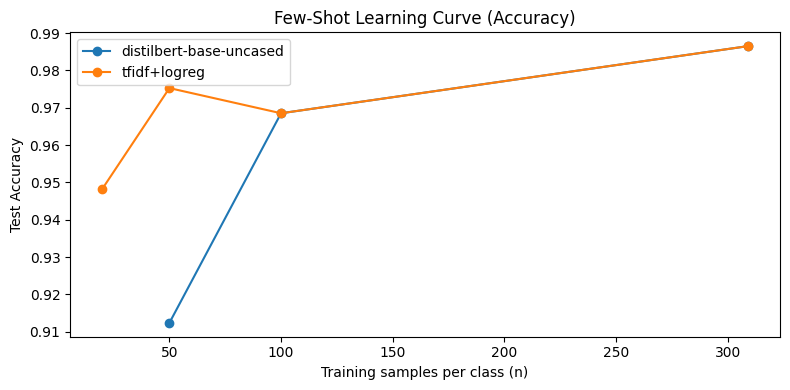

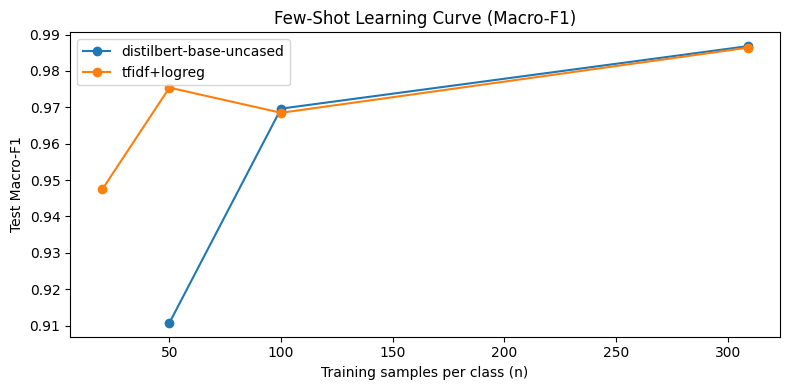

(WindowsPath('c:/CAS/cas-ml-document-classification/results/fewshot_learning/learning_curve_accuracy.png'),
 WindowsPath('c:/CAS/cas-ml-document-classification/results/fewshot_learning/learning_curve_macro_f1.png'))

In [13]:
import matplotlib.pyplot as plt

# Sortierung
df_plot = df_fewshot.sort_values(["model", "n_per_class"])

# Accuracy
plt.figure(figsize=(8,4))
for m in df_plot["model"].unique():
    sub = df_plot[df_plot["model"] == m].sort_values("n_per_class")
    plt.plot(sub["n_per_class"], sub["accuracy"], marker="o", label=m)

plt.xlabel("Training samples per class (n)")
plt.ylabel("Test Accuracy")
plt.title("Few-Shot Learning Curve (Accuracy)")
plt.legend()
plt.tight_layout()
acc_path = FEWSHOT_DIR / "learning_curve_accuracy.png"
plt.savefig(acc_path, dpi=300)
plt.show()

# Macro-F1
plt.figure(figsize=(8,4))
for m in df_plot["model"].unique():
    sub = df_plot[df_plot["model"] == m].sort_values("n_per_class")
    plt.plot(sub["n_per_class"], sub["macro_f1"], marker="o", label=m)

plt.xlabel("Training samples per class (n)")
plt.ylabel("Test Macro-F1")
plt.title("Few-Shot Learning Curve (Macro-F1)")
plt.legend()
plt.tight_layout()
f1_path = FEWSHOT_DIR / "learning_curve_macro_f1.png"
plt.savefig(f1_path, dpi=300)
plt.show()

acc_path, f1_path


Trainingszeit Plot

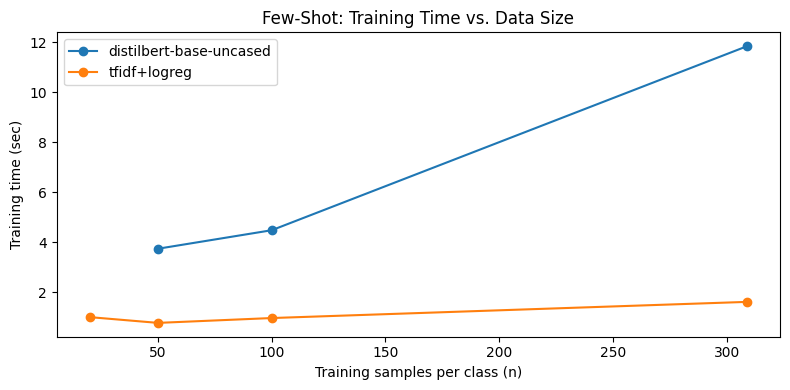

WindowsPath('c:/CAS/cas-ml-document-classification/results/fewshot_learning/learning_curve_train_time.png')

In [14]:
plt.figure(figsize=(8,4))
for m in df_plot["model"].unique():
    sub = df_plot[df_plot["model"] == m].sort_values("n_per_class")
    plt.plot(sub["n_per_class"], sub["train_time_sec"], marker="o", label=m)

plt.xlabel("Training samples per class (n)")
plt.ylabel("Training time (sec)")
plt.title("Few-Shot: Training Time vs. Data Size")
plt.legend()
plt.tight_layout()
time_path = FEWSHOT_DIR / "learning_curve_train_time.png"
plt.savefig(time_path, dpi=300)
plt.show()

time_path


## Interpretation

Die Learning Curves zeigen erwartungsgemäss, dass die Modellleistung mit zunehmender Anzahl gelabelter
Trainingsbeispiele pro Klasse steigt. Besonders im Few-Shot-Bereich (z. B. 20–100 Beispiele pro Klasse)
ist der Performance-Gewinn pro zusätzlich gelabeltem Dokument deutlich höher als bei großen Datenmengen
(Plateau-Effekt).

Für das ursprüngliche Ziel (Klassifikation persönlicher Dokumente mit ca. 500 Dokumenten insgesamt)
lässt sich ableiten, dass bei wenigen Beispielen pro Klasse eine robuste Klassifikation schwieriger wird.
Dies motiviert entweder (a) ein vereinfachtes Klassenschema, (b) gezieltes Labeling (Active Learning),
oder (c) Transfer Learning von grösseren, domänennäheren Datensätzen.


Allenfalls noch mit BERT laufen lassen - damit man Vergleich sieht, dass distilBERT schneller ist